In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import matplotlib as mpl
from matplotlib.pyplot import cm

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

In [5]:
import statsmodels.stats.multitest as multi

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Compiled RNA data

In [8]:
brian=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/tpm/tumor/pheno_all_zcancer",delimiter="\t")
firebrowse=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/firebrowse/pheno_all_zcancer",delimiter="\t")
pancan=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pancanatlas/pheno_all_zcancer",delimiter="\t")

In [9]:
del brian["IID"]
del firebrowse["IID"]
del pancan["IID"]

In [10]:
brian=brian.set_index("FID")
firebrowse=firebrowse.set_index("FID")
pancan=pancan.set_index("FID")

In [11]:
mp_ids={"CMC2":"C16orf61","ADGRE5":"CD97","SPRYD7":"C13orf1","JCHAIN":"IGJ","CTSL":"CTSL1","CTSV":"CTSL2","TEX30":"C13orf27","CENPU":"MLF1IP","CMSS1":"C3orf26","FAM216A":"C12orf24","HACD2":"PTPLB", "MARCHF1":"MARCH1"}
mp_ids= {v: k for k, v in mp_ids.items()}

In [12]:
brian=brian.rename(columns=mp_ids)
firebrowse=firebrowse.rename(columns=mp_ids)
pancan=pancan.rename(columns=mp_ids)

In [13]:
brian=brian.T
firebrowse=firebrowse.T
pancan=pancan.T

In [14]:
df=brian.append(firebrowse)
df=df.append(pancan)

In [15]:
#get only genes found in at least 2 rna sources
genes=pd.read_csv("/cellar/users/mpagadal/Data/gcta/notebooks/immune.genes.2.rna.txt")["genes"].tolist()
df=df[df.index.isin(genes)]

In [16]:
#replace missing values with np.nan
df=df.replace(-9,np.nan)

In [17]:
#get median of rna levels
df=df.groupby(df.index).median()

In [18]:
df_counts=df.isnull().sum().reset_index()

In [19]:
remove=df_counts[df_counts[0]>0.1*741]["index"].tolist()

In [21]:
len(remove)

867

In [22]:
df=df.T
df=df[~df.index.isin(remove)]

## Run for only heritable phenotypes

In [23]:
#filter for only gcta genes
sig=pd.read_csv("/cellar/users/mpagadal/Data/gcta/notebooks/gcta_significant_genes.txt",header=None)
#get only heritable genes
df=df.T
df=df[df.index.isin(sig[0].tolist())]
df=df.T

## Conduct PCA analysis

In [24]:
df=df.fillna(df.mean())

In [25]:
scaler=StandardScaler()
scaler.fit(df)
X_scaled=scaler.transform(df)

In [26]:
pca = PCA(n_components=30)

In [27]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### plot variable explained

In [28]:
mp_variance={}

for i,val in enumerate(pca.explained_variance_ratio_.tolist()):
    key="PC"+str(i+1)
    mp_variance[key]=val

Text(0, 0.5, 'variance explained')

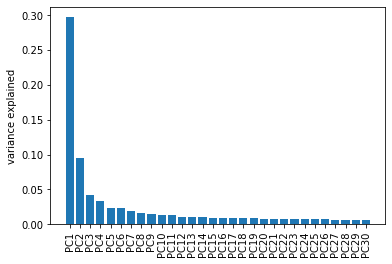

In [29]:
plt.bar(["PC"+str(i) for i in range(1,31)],pca.explained_variance_ratio_.tolist())
plt.xticks(rotation=90)
plt.ylabel("variance explained")

### get loadings

In [30]:
df_comp=pd.DataFrame(pca.components_)

In [31]:
df_comp.columns=df.columns

In [32]:
df_comp=df_comp.reset_index()

In [33]:
df_comp["index"]=df_comp["index"]+1

In [34]:
df_comp["index"]="PC"+df_comp["index"].astype(str)

In [35]:
df_comp=df_comp.set_index("index")

In [36]:
df_comp=df_comp.T

### Get pca dataframe

In [37]:
X_pca=pca.transform(X_scaled)

In [38]:
df_pca=pd.DataFrame(X_pca)
df_pca.index=df.index
df_pca.columns=["PC"+str(x+1) for x in df_pca.columns]

In [39]:
df_pca=df_pca.reset_index()

In [40]:
df_pca["IID"]=df_pca["index"]

In [41]:
df_pca=df_pca.rename(columns={"index":"FID"})

In [42]:
cols=["PC"+str(i) for i in range(1,11)]
pheno=df_pca[["FID","IID"]+cols]

In [43]:
pheno.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,TCGA-02-0047,TCGA-02-0047,1.313917,-3.680451,-2.795961,-0.931794,-1.040494,-1.262427,0.305199,0.854445,-0.406494,1.461017
1,TCGA-02-0055,TCGA-02-0055,10.244986,0.949089,0.799532,4.054242,0.697307,-4.205584,-2.015977,1.338300,-0.521153,1.108486
2,TCGA-02-2486,TCGA-02-2486,11.269077,3.172041,2.635661,1.957289,1.474399,-2.568069,2.035792,-1.576732,-1.355791,-1.786769
3,TCGA-06-0129,TCGA-06-0129,7.580760,-3.180433,2.907320,-2.147065,-1.486829,3.848854,1.881103,-1.438267,1.604929,-0.499645
4,TCGA-06-0130,TCGA-06-0130,15.852036,-0.546411,0.425608,0.254295,1.312483,-0.784558,-0.975156,0.316020,-0.467640,2.747459


### plot by cancer type

In [44]:
canc = pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/birdseed-processing/gtype.meta", delimiter="\t", header=None)
mp = canc.set_index(2)[0].to_dict()
df_pca["cancer"]=df_pca["FID"].map(mp)

Text(0, 0.5, 'PC2=0.09428801323805244')

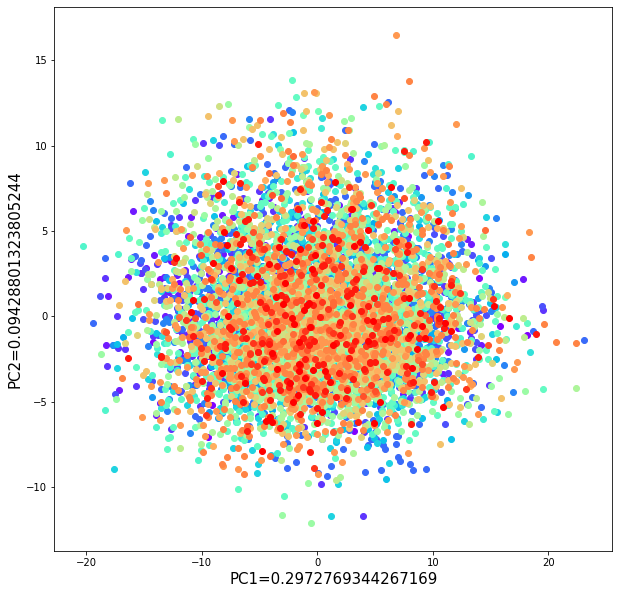

In [45]:
f=plt.figure(figsize=(10,10))

x="PC1"
y="PC2"

n=df_pca.cancer.unique()
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

for t, c in zip(n, color):
    plt.scatter(df_pca[df_pca.cancer==t][x], df_pca[df_pca.cancer==t][y], color=c)

plt.xlabel(x+"="+str(mp_variance[x]),fontsize=15)
plt.ylabel(y+"="+str(mp_variance[y]),fontsize=15)


## Run regression with principal components

In [46]:
df_pca_dummy=df_pca.join(pd.get_dummies(df_pca["cancer"]))

In [47]:
import sys
sys.path.insert(0, "/cellar/users/mpagadal/Programs/anaconda3/lib/python3.7/site-packages")
from sklearn import linear_model
from regressors import stats

In [48]:
pcs=df_pca_dummy.columns[1:11]
cancers=df_pca_dummy.columns[33:]

In [49]:
cancers=df_pca_dummy.columns[33:]

In [50]:
pcs

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], dtype='object')

In [51]:
cancers

Index(['ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'ESCA', 'GBM', 'HNSC',
       'KICH', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'OV',
       'PAAD', 'PCPG', 'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA',
       'UCEC', 'UCS', 'UVM'],
      dtype='object')

In [52]:
cancer=[]
pc=[]
pval=[]

for x in pcs:
    for c in cancers:
        ols = linear_model.LinearRegression()
        X=df_pca_dummy[c].values.reshape(-1, 1)
        y=df_pca_dummy[x].values.reshape(-1, 1)
        ols.fit(X, y)
        
        cancer.append(c)
        pc.append(x)
        pval.append(stats.coef_pval(ols, X, y)[1])

        

In [53]:
regress=pd.DataFrame({"cancer":cancer,"pc":pc,"pvalue":pval})

In [54]:
regress.sort_values(by="pvalue")

,cancer,pc,pvalue
107,OV,PC4,0.000034
137,OV,PC5,0.000205
47,OV,PC2,0.000372
17,OV,PC1,0.000891
275,COAD,PC10,0.002011
...,...,...,...
172,SARC,PC6,0.996306
166,MESO,PC6,0.996654
154,CHOL,PC6,0.997716
175,TGCT,PC6,0.998600


## Plot by highest loadings

In [55]:
rna=pd.read_csv("../processed_phenos/combined.rna.median.tsv",delimiter="\t")

In [56]:
rna=rna.rename(columns={"Unnamed: 0":"FID"})

In [57]:
all_pheno=pd.merge(df_pca,rna,on=["FID"],how="left")

In [58]:
all_pheno.head()

,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,XCL2,YTHDF1,ZFYVE9,ZWILCH,ZYX,dice.CD8_STIM,dice.M2,dice.TH1,melanoma.CAF,melanoma.Macrophages
0,TCGA-02-0047,1.313917,-3.680451,-2.795961,-0.931794,-1.040494,-1.262427,0.305199,0.854445,-0.406494,...,0.330488,-0.158347,0.531467,-0.389603,-1.006604,-0.602562,1.129960,0.183129,0.375867,0.496053
1,TCGA-02-0055,10.244986,0.949089,0.799532,4.054242,0.697307,-4.205584,-2.015977,1.338300,-0.521153,...,1.166109,-0.736059,-0.655539,0.421854,0.736365,1.875036,0.382398,-0.530246,2.508907,-0.103679
2,TCGA-02-2486,11.269077,3.172041,2.635661,1.957289,1.474399,-2.568069,2.035792,-1.576732,-1.355791,...,1.304002,-1.405787,-0.475998,-1.505941,0.118988,-0.331254,0.773243,1.112557,0.146880,1.380268
3,TCGA-06-0129,7.580760,-3.180433,2.907320,-2.147065,-1.486829,3.848854,1.881103,-1.438267,1.604929,...,-0.133997,-0.204520,1.068700,1.395036,-0.739006,0.414033,0.139010,-1.348535,-2.376622,2.641062
4,TCGA-06-0130,15.852036,-0.546411,0.425608,0.254295,1.312483,-0.784558,-0.975156,0.316020,-0.467640,...,2.641062,-0.436986,-1.477779,1.671197,0.913797,-0.243910,1.419171,0.513783,1.694840,1.705324


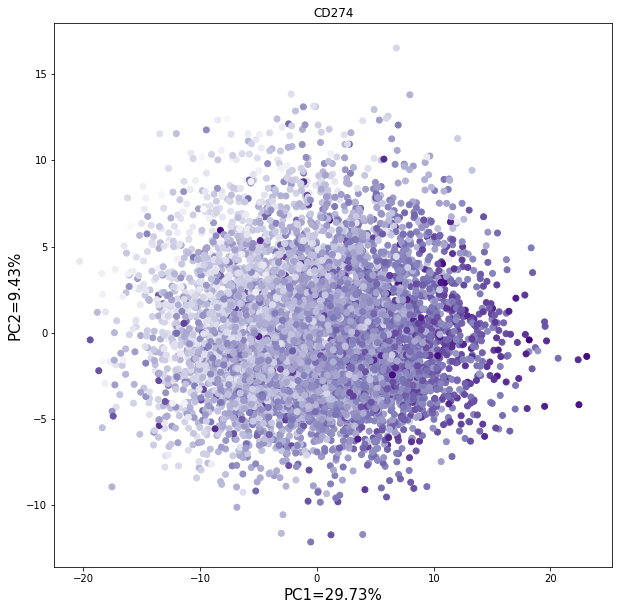

In [59]:
f=plt.figure(figsize=(10,10))

x="PC1"
y="PC2"
gene="CD274"

plt.scatter(all_pheno[x], all_pheno[y], c=all_pheno[gene],cmap="Purples")


plt.xlabel(x+"="+"{0:.2f}%".format(mp_variance[x]*100),fontsize=15)
plt.ylabel(y+"="+"{0:.2f}%".format(mp_variance[y]*100),fontsize=15)
plt.title(gene)
plt.savefig(gene+".pdf")

In [62]:
x="PC1"
y="Macrophage.Regulation"

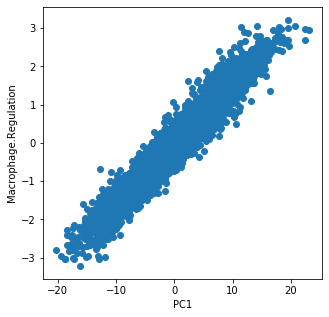

In [63]:
f=plt.figure(figsize=(5,5))
plt.scatter(all_pheno[x],all_pheno[y])
plt.xlabel(x)
plt.ylabel(y)
plt.savefig(x+"."+y+".pdf")

In [109]:
all_pheno_filt=all_pheno[~all_pheno["Macrophage.Regulation"].isnull()]

In [118]:
X=all_pheno_filt["CD274"]
y=all_pheno_filt["PC3"].values.reshape(-1, 1)
X = sm.add_constant(X)
model=sm.OLS(y,X)
results=model.fit()

In [119]:
results.params

const    0.024190
CD274    0.665915
dtype: float64

In [120]:
results.pvalues[1]

2.6275726987730346e-115

In [117]:
max(results.pvalues[1], sys.float_info.min)

2.2250738585072014e-308

In [82]:
results.pvalues

array([5.41690853e-07, 0.00000000e+00])

In [76]:
results.params

AttributeError: 'LinearRegression' object has no attribute 'params'

In [175]:
pheno.to_csv("/cellar/users/mpagadal/Data/projects/germline-immune/processed_phenos/pca/pca.pheno.heritable.tsv",index=None,sep="\t")

## Get PCs for both gcta and all phenos

In [134]:
gcta=pd.read_csv("../processed_phenos/pca/pca.pheno.heritable.tsv",delimiter="\t")
pheno=pd.read_csv("../processed_phenos/pca/pca.pheno.tsv",delimiter="\t")

In [135]:
all_pca=pd.merge(gcta,pheno,on=["FID","IID"],suffixes=("_all","_gcta"))

In [136]:
del all_pca["FID"]
del all_pca["IID"]

In [137]:
all_pca=abs(all_pca)

In [138]:
all_pca.head()

,PC1_all,PC2_all,PC3_all,PC4_all,PC5_all,PC6_all,PC7_all,PC8_all,PC9_all,PC10_all,PC1_gcta,PC2_gcta,PC3_gcta,PC4_gcta,PC5_gcta,PC6_gcta,PC7_gcta,PC8_gcta,PC9_gcta,PC10_gcta
0,1.313917,3.680450,2.795920,0.931772,1.040448,1.262522,0.303719,0.858296,0.403122,1.461166,1.784737,13.135899,4.176562,2.460464,0.402273,0.146864,2.791070,0.106347,0.010014,2.205814
1,10.244986,0.949089,0.799498,4.054130,0.696704,4.205255,2.016507,1.337999,0.534810,1.097614,16.918073,4.185367,1.991697,10.002315,8.131188,1.491205,2.363470,1.172913,6.483940,2.196060
2,11.269077,3.172041,2.635656,1.957362,1.474086,2.568502,2.037273,1.580704,1.359331,1.795065,19.290299,4.729950,2.553463,5.562093,11.303328,4.955355,3.219751,3.138193,1.477335,3.424130
3,7.580760,3.180431,2.907188,2.147122,1.487361,3.849738,1.881467,1.429179,1.600554,0.506509,9.078792,6.140856,11.869096,8.355814,9.092941,3.041594,2.247341,7.898231,4.755307,0.433890
4,15.852036,0.546411,0.425554,0.254357,1.312823,0.784748,0.974725,0.324995,0.463043,2.749847,32.572916,1.812889,5.821054,4.160008,0.383361,0.253562,2.124778,1.230449,6.145078,0.060518


In [139]:
all_pca_pearson=all_pca.corr(method="pearson")

In [140]:
cols=[x for x in all_pca_pearson.columns if "gcta" in x]
ind=[x for x in all_pca_pearson.columns if "all" in x]

In [141]:
all_pca_pearson_compare=all_pca_pearson.loc[ind,cols]

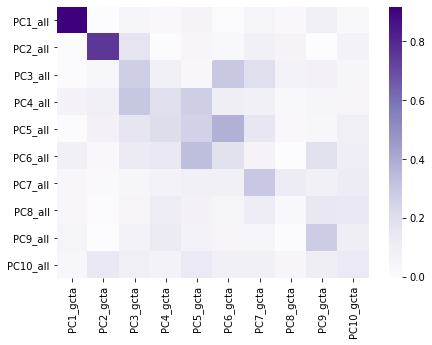

In [142]:
f=plt.figure(figsize=(7,5))
sns.heatmap(all_pca_pearson_compare,cmap="Purples")
plt.savefig("pca.heatmap.pdf")

## See if PCs correlated with age or sex

In [144]:
gcta

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,TCGA-02-0047,TCGA-02-0047,1.313917,-3.680450,-2.795920,-0.931772,-1.040448,-1.262522,0.303719,0.858296,-0.403122,1.461166
1,TCGA-02-0055,TCGA-02-0055,10.244986,0.949089,0.799498,4.054130,0.696704,-4.205255,-2.016507,1.337999,-0.534810,1.097614
2,TCGA-02-2486,TCGA-02-2486,11.269077,3.172041,2.635656,1.957362,1.474086,-2.568502,2.037273,-1.580704,-1.359331,-1.795065
3,TCGA-06-0129,TCGA-06-0129,7.580760,-3.180431,2.907188,-2.147122,-1.487361,3.849738,1.881467,-1.429179,1.600554,-0.506509
4,TCGA-06-0130,TCGA-06-0130,15.852036,-0.546411,0.425554,0.254357,1.312823,-0.784748,-0.974725,0.324995,-0.463043,2.749847
...,...,...,...,...,...,...,...,...,...,...,...,...
7337,TCGA-YZ-A983,TCGA-YZ-A983,1.100562,-3.841935,0.310320,1.237850,3.237445,0.547916,0.041825,0.131259,0.065911,-0.619678
7338,TCGA-YZ-A984,TCGA-YZ-A984,-6.758322,2.154779,-2.119330,1.063169,-4.086451,-0.884226,1.262083,-0.924094,-1.386335,-0.443494
7339,TCGA-YZ-A985,TCGA-YZ-A985,-3.585884,1.136864,-0.643923,-1.820074,-3.418758,-0.196116,-2.003668,-0.569276,-0.660365,-1.390243
7340,TCGA-L5-A88T,TCGA-L5-A88T,0.484636,-1.819653,-2.618451,-2.510536,-2.702607,-0.988434,0.005735,-0.694961,-0.203901,-1.208093


In [155]:
cov=pd.read_csv("/cellar/users/mpagadal/Data/plink-associations/covs/cov-immune-filt.txt",delimiter="\t")
mp_age=dict(zip(cov["FID"],cov["age"]))

In [158]:
fam=pd.read_csv("/nrnb/users/mpagadal/tcga-genotypes/imputation/michigan-imputation/HRC/european.final.noimmunecancers.clean.fam",delim_whitespace=True,header=None)
mp_sex=dict(zip(fam[0],fam[4]))


In [160]:
gcta["age"]=gcta["FID"].map(mp_age)
gcta["sex"]=gcta["FID"].map(mp_sex)

In [177]:
gcta.head()

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,age,sex
0,TCGA-02-0047,TCGA-02-0047,1.313917,-3.680450,-2.795920,-0.931772,-1.040448,-1.262522,0.303719,0.858296,-0.403122,1.461166,78,1
1,TCGA-02-0055,TCGA-02-0055,10.244986,0.949089,0.799498,4.054130,0.696704,-4.205255,-2.016507,1.337999,-0.534810,1.097614,62,2
2,TCGA-02-2486,TCGA-02-2486,11.269077,3.172041,2.635656,1.957362,1.474086,-2.568502,2.037273,-1.580704,-1.359331,-1.795065,64,1
3,TCGA-06-0129,TCGA-06-0129,7.580760,-3.180431,2.907188,-2.147122,-1.487361,3.849738,1.881467,-1.429179,1.600554,-0.506509,30,1
4,TCGA-06-0130,TCGA-06-0130,15.852036,-0.546411,0.425554,0.254357,1.312823,-0.784748,-0.974725,0.324995,-0.463043,2.749847,54,1


In [178]:
table=pd.DataFrame()

for y in ["age","sex"]:
    for x in range(10):
        Y=gcta["PC"+str(x+1)]
        X=gcta[y]
        X = sm.add_constant(X)
        model = sm.OLS(Y,X)
        
        results = model.fit()
        params=results.params.reset_index()
        pvals=results.pvalues.reset_index()
        df=pd.merge(params,pvals,on="index",how="left")
        df.columns=["variable","param","p"]
        df["PC"]="PC"+str(x+1)
        table=table.append(df)
        
        
        

In [181]:
table=table[table["variable"].isin(["age","sex"])]

In [184]:
table=table.pivot(index="PC",columns="variable",values="p")

In [190]:
table.to_csv("pca.age.sex.csv")

In [186]:
pd.options.display.float_format = "{:,.2f}".format

In [188]:
table

variable,age,sex
PC,,
PC1,0.26,0.97
PC10,0.19,0.74
PC2,0.01,0.43
PC3,0.43,0.78
PC4,0.93,0.09
PC5,0.19,0.41
PC6,0.59,0.79
PC7,0.14,0.06
PC8,0.00,0.12


In [163]:
Y=gcta["PC1"]
X=gcta["age"]
X = sm.add_constant(X)

In [164]:
model = sm.OLS(Y,X)

In [165]:
results = model.fit()

In [170]:
params=results.params.reset_index()

In [171]:
pvals=results.pvalues.reset_index()

In [172]:
pvals

,index,0
0,const,0.273372
1,age,0.257852


In [175]:
df=pd.merge(params,pvals,on="index",how="left")
df.columns=["variable","param","p"]


In [176]:
df

,variable,param,p
0,const,-0.325356,0.273372
1,age,0.005455,0.257852


In [154]:
cov.columns

Index(['FID', 'IID', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'age', 'B.cells.naive', 'B.cells.memory', 'Plasma.cells',
       'T.cells.CD8', 'T.cells.CD4.naive', 'T.cells.CD4.memory.resting',
       'T.cells.CD4.memory.activated', 'T.cells.follicular.helper',
       'T.cells.regulatory.Tregs', 'T.cells.gamma.delta', 'NK.cells.resting',
       'NK.cells.activated', 'Monocytes', 'Macrophages.M0', 'Macrophages.M1',
       'Macrophages.M2', 'Dendritic.cells.resting',
       'Dendritic.cells.activated', 'Mast.cells.resting',
       'Mast.cells.activated', 'Eosinophils', 'Neutrophils', 'TISSUE'],
      dtype='object')